In [ ]:
import os
import sys
import copy
import json
import torch
import signal
import warnings
import pandas as pd
from pathlib import Path
import concurrent.futures
import lightning.pytorch as pl
from flask import Flask, request

from sklearn.metrics import mean_squared_error
from pytorch_forecasting.data import NaNLabelEncoder
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import MAE

from lightning.pytorch.tuner import Tuner



/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [ ]:




import lightning.pytorch as pl

from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)
from sklearn.preprocessing import StandardScaler

In [ ]:
data_path = "./rooms/F1_R1.csv"

max_encoder_length = 48
max_prediction_length = 5

lr = 3e-4
epochs = 5
batch_size = 128

In [74]:
df = pd.read_csv(data_path)
df["series"] = 0

scaler = StandardScaler()
df["electricity"] = scaler.fit_transform(df[["electricity"]])
df["co2"] = scaler.fit_transform(df[["co2"]])
df["humidity"] = scaler.fit_transform(df[["humidity"]])
df["temperature"] = scaler.fit_transform(df[["temperature"]])
df["hour"] = df["hour"].astype(str)
df["day"] = df["day"].astype(str)
df["month"] = df["month"].astype(str)
df = df.sort_values(["room_id", "timestamp"]).reset_index(drop=True)
df["time_idx"] = df.groupby("room_id").cumcount()
training_cutoff = df["time_idx"].max() - max_prediction_length

train_dataset = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="electricity",
    group_ids=["series"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["room_id"],
    static_reals=["area", "num_windows", "window_area"],
    time_varying_known_categoricals=["hour", "day", "month"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["humidity", "temperature", "co2", "electricity"],
    target_normalizer=None,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size)

val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset, df, predict=True, stop_randomization=True
)
val_dataloader = val_dataset.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

In [78]:
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor(0.2192, device='mps:0')

In [9]:
model = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=lr,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    loss=MAE(),
    output_size=1,
    log_interval=10,
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in network: {model.size() / 1e3:.1f}k")

/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 25.4k


In [10]:
trainer = pl.Trainer(
    accelerator="cpu"
)

res = Tuner(trainer).lr_find(
    model,
    train_dataloaders=train_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to en

suggested learning rate: 0.2884031503126607


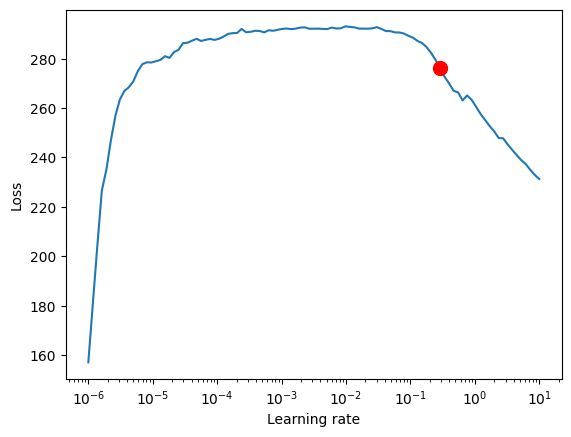

/var/folders/fc/9w7nbmnj2y10_sl912glk3240000gn/T/ipykernel_56308/3284506899.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [ ]:
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [17]:
trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="cpu",
    enable_model_summary=True
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [18]:
trainer.fit(
    model,
    train_dataloaders=train_dataloader
)

/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 208    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 2.4 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.9 K  | train
6  | decoder_variable_selection         | Variabl

Epoch 1:  40%|████      | 2/5 [00:00<00:00, 10.83it/s, v_num=1, train_loss_step=251.0, train_loss_epoch=282.0]

/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:464: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 11.27it/s, v_num=1, train_loss_step=146.0, train_loss_epoch=141.0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 10.44it/s, v_num=1, train_loss_step=146.0, train_loss_epoch=141.0]
